<a href="https://colab.research.google.com/github/srinivasbharani/Advanced-Regression---Machine-Learning/blob/main/FGSM_3_Defenses_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoded vectors
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [3]:
# Create DNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [4]:
# Craft C&W Attack (Simplified version)
def carlini_wagner_attack(model, x, y, eps=0.1, steps=10, alpha=0.01):
    x_adv = tf.identity(x)
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(y, logits)
        gradients = tape.gradient(loss, x_adv)
        x_adv += alpha * tf.sign(gradients)
        x_adv = tf.clip_by_value(x_adv, x - eps, x + eps)
        x_adv = tf.clip_by_value(x_adv, 0, 1)
    return x_adv


In [5]:
# # Adversarial Training
# def adversarial_training(model, x_train, y_train, epsilon=0.05, epochs=10, batch_size=32):
#     for epoch in range(epochs):
#         x_train_adv = fgsm_attack(model, x_train, y_train, epsilon=epsilon)
#         model.fit(x_train_adv, y_train, epochs=1, batch_size=batch_size)
#         return model


In [6]:
# Helper function for defensive distillation
def softmax_with_temperature(logits, temperature):
    exp_logits = np.exp(logits / temperature)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


In [7]:
# Generate adversarial data
x_test_adv = carlini_wagner_attack(create_model(), x_test, y_test)
print(len(x_test_adv))

10000


In [8]:
# Create and train the clean model
clean_model = create_model()
clean_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
clean_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5146 - accuracy: 0.4470 - val_loss: 1.2038 - val_accuracy: 0.5729
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1450 - accuracy: 0.5951 - val_loss: 1.1585 - val_accuracy: 0.5930
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9998 - accuracy: 0.6498 - val_loss: 0.9744 - val_accuracy: 0.6606
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9067 - accuracy: 0.6832 - val_loss: 0.9418 - val_accuracy: 0.6663
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8386 - accuracy: 0.7067 - val_loss: 0.9093 - val_accuracy: 0.6797
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7793 - accuracy: 0.7256 - val_loss: 0.8704 - val_accuracy: 0.6946
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.7313 - accuracy: 0.7436 - val_loss: 0.8882 - val_a

In [9]:
print(len(x_train))

50000


In [10]:
# Evaluate accuracy on clean test data
_, clean_accuracy = clean_model.evaluate(x_test, y_test, verbose=0)
print(clean_accuracy)

0.7146999835968018


In [11]:
# Evaluate accuracy on adversarial test data
_, clean_adv_accuracy = clean_model.evaluate(x_test_adv, y_test, verbose=0)
print(clean_adv_accuracy)

0.692300021648407


In [13]:
# Adversarial Training with C&W attack on clean model
adv_model = create_model()
adv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# adversarial_training(adv_model, x_train, y_train)#, epsilon=0.05, epochs=10, batch_size=32)
x_train_adv = carlini_wagner_attack(clean_model, x_train, y_train)
print(len(x_train_adv))
x_train_adv_2 = np.concatenate([x_train, x_train_adv])
print(len(x_train_adv_2))
y_train_2 = np.concatenate([y_train, y_train])
print(len(y_train_2))

50000
100000
100000


In [14]:
adv_model.fit(x_train_adv_2, y_train_2, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
3125/3125 [==============================] - 30s 9ms/step - loss: 1.5667 - accuracy: 0.4256 - val_loss: 1.3227 - val_accuracy: 0.5189
Epoch 2/10
3125/3125 [==============================] - 28s 9ms/step - loss: 1.2637 - accuracy: 0.5539 - val_loss: 1.2016 - val_accuracy: 0.5667
Epoch 3/10
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0863 - accuracy: 0.6198 - val_loss: 1.2342 - val_accuracy: 0.5608
Epoch 4/10
3125/3125 [==============================] - 27s 9ms/step - loss: 0.9601 - accuracy: 0.6648 - val_loss: 1.1861 - val_accuracy: 0.5885
Epoch 5/10
3125/3125 [==============================] - 27s 9ms/step - loss: 0.8690 - accuracy: 0.6979 - val_loss: 1.1904 - val_accuracy: 0.5911
Epoch 6/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.7981 - accuracy: 0.7227 - val_loss: 1.1677 - val_accuracy: 0.6100
Epoch 7/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.7456 - accuracy: 0.7409 - val_loss: 1.2063 - val_ac

In [15]:
# Evaluate accuracy of adversarial training model on clean test data
_, adv_train_accuracy_clean = adv_model.evaluate(x_test, y_test, verbose=0)
print(adv_train_accuracy_clean)

0.6190000176429749


In [16]:
# Evaluate accuracy of adversarial training model on adversarial test data
_, adv_train_accuracy_adv = adv_model.evaluate(x_test_adv, y_test, verbose=0)
print(adv_train_accuracy_adv)

0.5896000266075134


In [17]:
# Adversarial Training with Gradient Masking
adv_model_gm = create_model()
adv_model_gm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for _ in range(10):
    x_train_masked = x_train + 0.1 * np.sign(np.random.randn(*x_train.shape))
    x_train_masked = np.clip(x_train_masked, 0, 1)
#     adv_model_gm.fit(x_train_masked, y_train, epochs=1, batch_size=32)
    adv_model.fit(x_train_masked, y_train, epochs=1, batch_size=32)
    


1563/1563 [==============================] - 16s 10ms/step - loss: 0.6447 - accuracy: 0.7708


In [18]:
# Evaluate accuracy on adversarial training model with gradient masking
_, adv_train_accuracy_gm_clean = adv_model.evaluate(x_test, y_test, verbose=0)
print(adv_train_accuracy_gm_clean)

0.6389999985694885


In [19]:
# Evaluate accuracy on adversarial test data with gradient masking
_, adv_train_accuracy_gm_adv = adv_model.evaluate(x_test_adv, y_test, verbose=0)
print(adv_train_accuracy_gm_adv)

0.6547999978065491


In [20]:
# Defensive Distillation
defensive_distillation_model = create_model()
defensive_distillation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Soft targets from the trained model with temperature
temperature = 3.0
soft_targets = softmax_with_temperature(adv_model.predict(x_train), temperature)
soft_targets_test = softmax_with_temperature(adv_model.predict(x_test), temperature)


defensive_distillation_model.fit(x_train, soft_targets, epochs=10, batch_size=32)

313/313 [==============================] - 1s 2ms/step
Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.3012 - accuracy: 0.4960
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3003 - accuracy: 0.6506
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3001 - accuracy: 0.6965
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2999 - accuracy: 0.7204
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2998 - accuracy: 0.7342
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2997 - accuracy: 0.7498
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2997 - accuracy: 0.7601
Epoch 8/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2996 - accuracy: 0.7675
Epoch 9/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2996 - accuracy: 0.7751
Epoch 10/10
1563/1

In [22]:
# Evaluate accuracy of defensive distillation model on clean and adversarial test data
_, defensive_distillation_clean_accuracy = defensive_distillation_model.evaluate(x_test, y_test, verbose=0)
x_test_adv_soft = softmax_with_temperature(clean_model.predict(x_test_adv), temperature)
_, defensive_distillation_adv_accuracy = defensive_distillation_model.evaluate(x_test_adv, x_test_adv_soft, verbose=0)
print(defensive_distillation_clean_accuracy)
print(defensive_distillation_adv_accuracy)

313/313 [==============================] - 1s 3ms/step
0.6664000153541565
0.6280999779701233


In [23]:
# Calculate robustness scores
robustness_score_clean = clean_adv_accuracy / clean_accuracy
robustness_score_adv = adv_train_accuracy_adv / clean_accuracy
robustness_score_gm_clean = adv_train_accuracy_gm_clean / clean_accuracy
robustness_score_gm_adv = adv_train_accuracy_gm_adv / clean_accuracy
robustness_score_dd_clean = defensive_distillation_clean_accuracy / clean_accuracy
robustness_score_dd_adv = defensive_distillation_adv_accuracy / clean_accuracy


In [24]:
# Generate confusion matrices
def generate_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


313/313 [==============================] - 1s 2ms/step


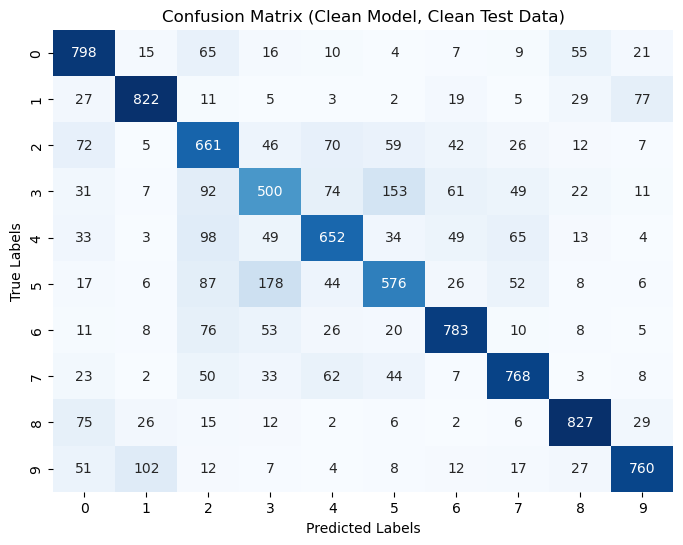

In [25]:
# Confusion matrix for clean model on clean test data
y_pred_clean = np.argmax(clean_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_clean, "Confusion Matrix (Clean Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


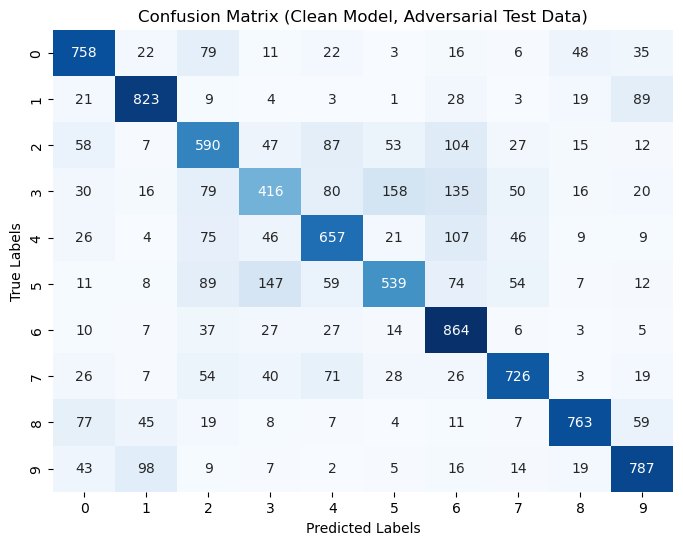

In [26]:
# Confusion matrix for clean model on adversarial test data
y_pred_clean_adv = np.argmax(clean_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_clean_adv, "Confusion Matrix (Clean Model, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


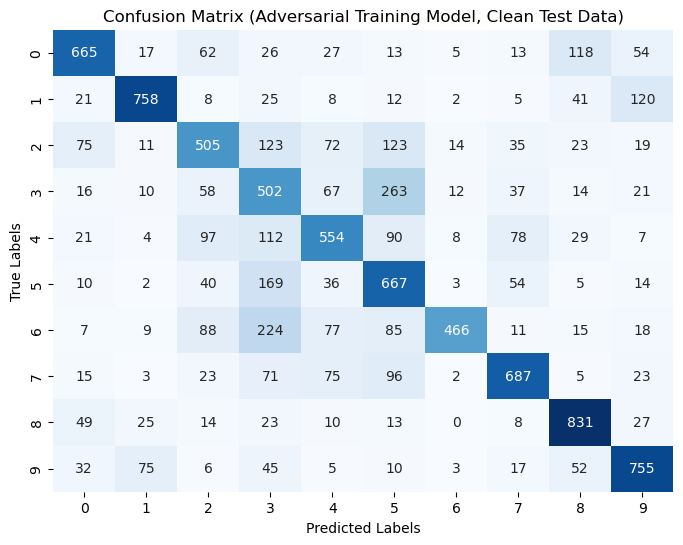

In [27]:
# Confusion matrix for adversarial training model on clean test data
y_pred_adv_train_clean = np.argmax(adv_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_clean, "Confusion Matrix (Adversarial Training Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


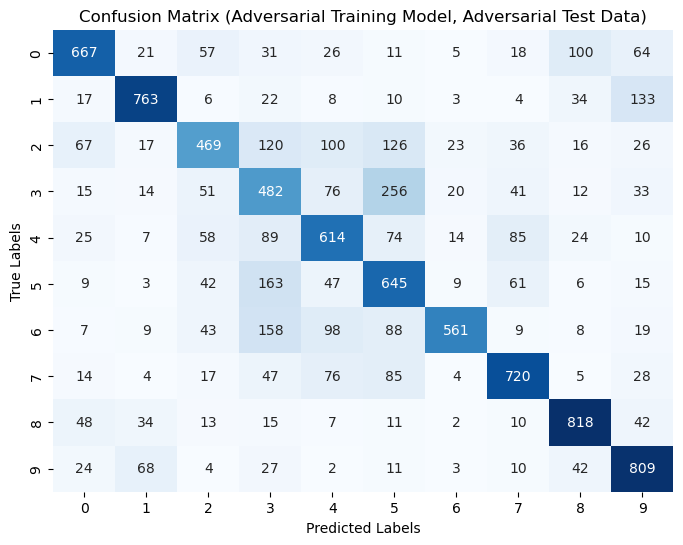

In [28]:
# Confusion matrix for adversarial training model on adversarial test data
y_pred_adv_train_adv = np.argmax(adv_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_adv, "Confusion Matrix (Adversarial Training Model, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


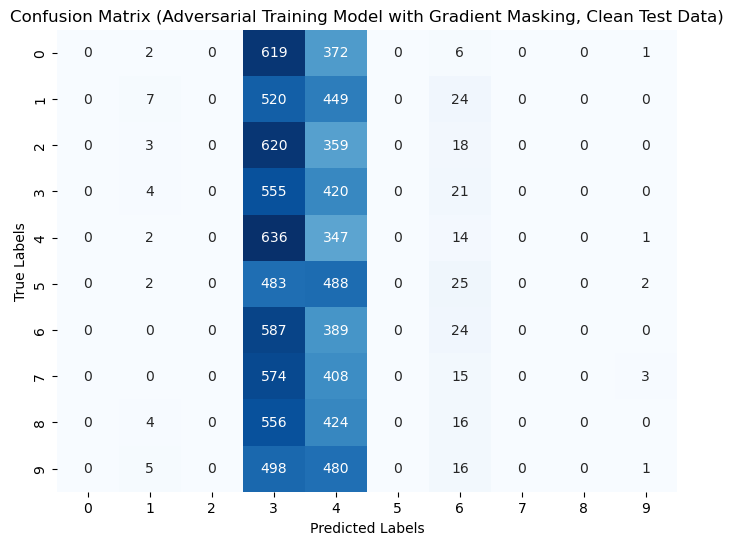

In [29]:
# Confusion matrix for adversarial training model with gradient masking on clean test data
y_pred_adv_train_gm_clean = np.argmax(adv_model_gm.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_gm_clean, "Confusion Matrix (Adversarial Training Model with Gradient Masking, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


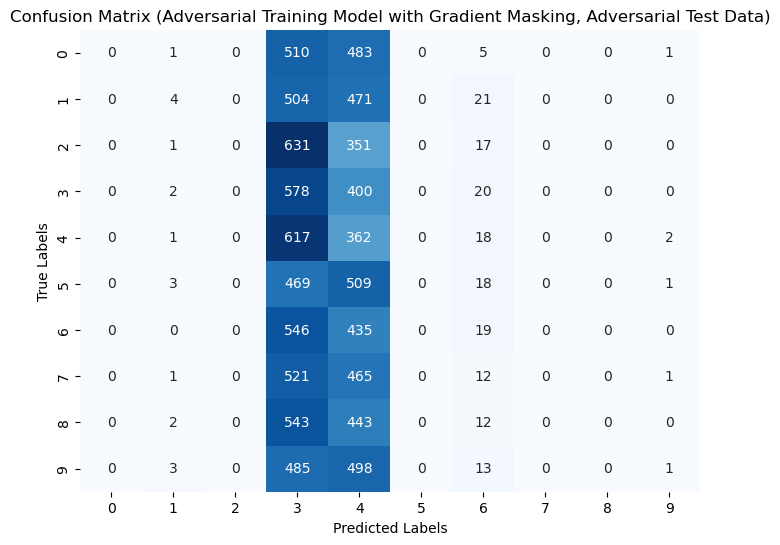

In [30]:
# Confusion matrix for adversarial training model with gradient masking on adversarial test data
y_pred_adv_train_gm_adv = np.argmax(adv_model_gm.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_gm_adv, "Confusion Matrix (Adversarial Training Model with Gradient Masking, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


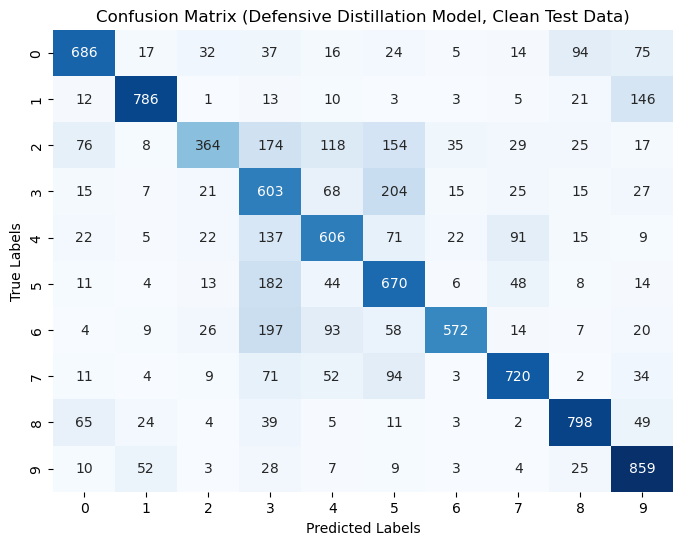

In [31]:
# Confusion matrix for defensive distillation model on clean test data
y_pred_def_dist_clean = np.argmax(defensive_distillation_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_def_dist_clean, "Confusion Matrix (Defensive Distillation Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


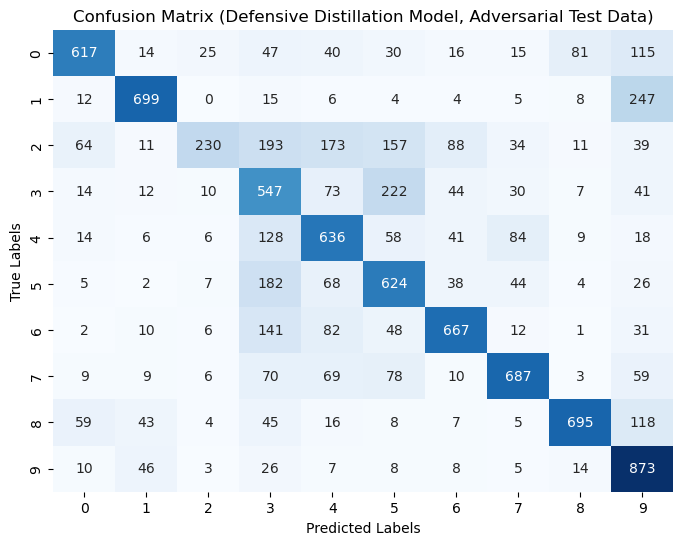

In [32]:
# Confusion matrix for defensive distillation model on adversarial test data
y_pred_def_dist_adv = np.argmax(defensive_distillation_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_def_dist_adv, "Confusion Matrix (Defensive Distillation Model, Adversarial Test Data)")


In [33]:
# Print accuracy and robustness scores
print("Clean Model Accuracy:", clean_accuracy)
print("Clean Model Robustness Score:", robustness_score_clean)

print("Adversarial Training Model Accuracy on Clean Data:", adv_train_accuracy_clean)
print("Adversarial Training Model Robustness Score on Clean Data:", robustness_score_adv)

print("Adversarial Training Model with Gradient Masking Accuracy on Clean Data:", adv_train_accuracy_gm_clean)
print("Adversarial Training Model with Gradient Masking Robustness Score on Clean Data:", robustness_score_gm_clean)

print("Defensive Distillation Model Accuracy on Clean Data:", defensive_distillation_clean_accuracy)
print("Defensive Distillation Model Robustness Score on Clean Data:", robustness_score_dd_clean)

Clean Model Accuracy: 0.7146999835968018
Clean Model Robustness Score: 0.9686582307786483
Adversarial Training Model Accuracy on Clean Data: 0.6190000176429749
Adversarial Training Model Robustness Score on Clean Data: 0.8249615784798121
Adversarial Training Model with Gradient Masking Accuracy on Clean Data: 0.6389999985694885
Adversarial Training Model with Gradient Masking Robustness Score on Clean Data: 0.8940814512876505
Defensive Distillation Model Accuracy on Clean Data: 0.6664000153541565
Defensive Distillation Model Robustness Score on Clean Data: 0.9324192397492852


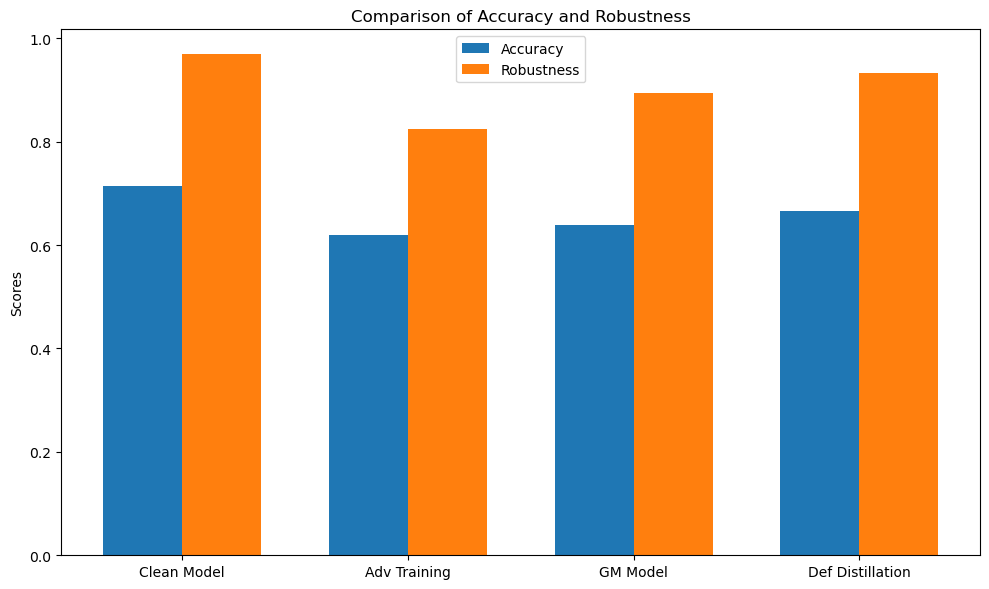

In [34]:
# Plot comparison graph
labels = ['Clean Model', 'Adv Training', 'GM Model', 'Def Distillation']
accuracy_scores = [clean_accuracy, adv_train_accuracy_clean, adv_train_accuracy_gm_clean, defensive_distillation_clean_accuracy]
robustness_scores = [robustness_score_clean, robustness_score_adv, robustness_score_gm_clean, robustness_score_dd_clean]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, robustness_scores, width, label='Robustness')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and Robustness')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()